In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/delicious_csv

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13yb9Wec53hrGTpqc2YkxagXDWQUnP-5Y/delicious_csv


In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [ ]:
item_embeddings = pd.read_csv("norm_matrix_ejml_full_delicious.csv", header=None)
item_embeddings.sort_values(0, inplace=True)
book = pd.read_csv("bookmarks.csv")
book_tags = pd.read_csv("bookmark_tags.csv")
tags = pd.read_csv("tags.csv")
user_contacts = pd.read_csv("user_contacts.csv")
user_contacts_t = pd.read_csv("user_contacts-timestamps.csv")
user_taggedb = pd.read_csv("user_taggedbookmarks.csv")
user_taggedbt = pd.read_csv("user_taggedbookmarks-timestamps.csv")

In [ ]:
idx_to_item = {idx: item for idx, item in enumerate(item_embeddings[0].to_list())}
item_set = set(item_embeddings[0].to_list())
item_to_idx = {v: k for k, v in idx_to_item.items()}
idx_to_user = {idx: user for idx, user in enumerate(sorted(list(set(user_taggedb['userID']))))}
user_to_idx = {v: k for k, v in idx_to_user.items()}

In [ ]:
user_to_book = []
for idx, user in idx_to_user.items():
  user_to_book.append((user, sorted(list(set(user_taggedb[user_taggedb["userID"] == user]["bookmarkID"])))))
user_to_items = {user: items for user, items in user_to_book}
pca = item_embeddings.iloc[:, 1:].to_numpy()

In [ ]:
c = 0
for _, i in user_to_items.items():
  if len(i) > 29:
    c += 1
print(c)

1530


First, we'll try reproducing the algorithm in "Online Interactive Collaborative Filtering Using Multi-Armed Bandit with Dependent Arms", which is an LDA-based clustering algorithm.


In [ ]:
num_particles = 4
num_items = pca.shape[0]
D = pca.shape[1]
K = D # Number of topics (or clusters) is forced to be equal to PCA dimension,
      # since we're not generating feature vectors
num_users = len(idx_to_user)
num_contexts = 25

# Hyperparameters
eta = np.ones(num_items) #/ num_items
lamda = np.ones(K) #/ K
alpha = 1
beta = 1
# The below are irrelevant due to above
# mu_q = np.zeros(D)
# Sigma_q = 

In [ ]:
def get_contexts(user_idx, num_contexts):
  user = idx_to_user[user_idx]
  items = user_to_items[user]
  items_idx = np.array([item_to_idx[item] for item in items if item in item_set])

  good_item_idx = np.random.choice(items_idx, 1)
  good_item_context = pca[good_item_idx]
  bad_items_idx = np.random.choice(np.setdiff1d(range(num_items), items_idx), num_contexts - 1, replace=False) 
  bad_items_contexts = pca[bad_items_idx]
    
  contexts = np.vstack((good_item_context, bad_items_contexts))
  rewards = np.array([1] + (num_contexts - 1) * [0]) #-1/(num_contexts - 1)])
  idxs = np.concatenate((good_item_idx, bad_items_idx))

  return contexts, rewards, idxs

In [ ]:
def evaluate(u, particles):
  cu_rewards = np.zeros(num_contexts)
  for particle in particles:
    p = particle["p"][u, :]
    item_feats, r_rewards, item_idxs = get_contexts(u, num_contexts)
    for i in range(item_feats.shape[0]):
      cu_rewards[i] += np.random.normal(item_feats[i, :]@p, particle["sigma"][item_idxs[i]])
  av_rewards = cu_rewards / len(particles)
  return av_rewards, r_rewards, item_idxs

In [ ]:
def update(u, s, r, particles):
  weights = np.zeros(len(particles))
  for idx, particle in enumerate(particles):
    # Review - seems to be some error in the paper
    # for k in range(K): # todo - vectorize
    #  weights[idx] += (1 / (2 * np.pi * particle["sigma"][s])**0.5) * np.exp(-(r - particle["p"][u, :]@pca[s, :])**2) 
    #              * (particle["p"][u, k] / np.sum(particle["p"][u, :])) * (particle["phi"][k, s] / np.sum(particle["phi"][k, :]))
    weights[idx] += (1 / (2 * np.pi * particle["sigma"][s])**0.5) * np.exp(-(r - particle["p"][u, :]@pca[s, :])**2/(2 * particle["sigma"][s])) * (particle["eta"][s] / np.sum(particle["eta"]))
  weights /= np.sum(weights)
  for idx, particle in enumerate(particles):
    flag = np.random.binomial(1, weights[idx])
    if flag == 0:
      continue
    else:
      particle["sigma"] = np.reciprocal(np.random.gamma(particle["alpha"], 1 / particle["beta"], num_items))
      particle["p"] = np.random.dirichlet(particle["lambda"], size=num_users)
      particle["phi"] = np.random.dirichlet(particle["eta"], size=K)
      particle["z"] = np.array([np.random.multinomial(1, particle["p"][i, :]) for i in range(num_users)])
  for particle in particles:
    # Sufficient statistics for z
    e_p = (particle["z"][u, :].copy() * r + particle["lambda"].copy())
    e_p /= np.sum(e_p)
    e_phi = particle["eta"].copy()
    e_phi[s] += r
    e_phi /= np.sum(e_phi)
    theta = (e_p.copy() * e_phi[s])
    theta /= np.sum(theta)
    # Resample z as per new posterior
    particle["z"][u, :] = np.random.multinomial(1, theta)
    # print(particle["z"][u, :])
    # Update sufficient statistics
    particle["alpha"] += 0.5
    particle["beta"] += 0.5 * r**2
    particle["lambda"] += particle["z"][u, :] * r
    # print(particle["lambda"]) 
    particle["eta"][s] += r
    # print(particle["eta"][s], particle["eta"])
    # Resample everything
    particle["sigma"] = np.reciprocal(np.random.gamma(particle["alpha"], 1 / particle["beta"], num_items))
    particle["p"] = np.random.dirichlet(particle["lambda"], size=num_users)
    particle["phi"] = np.random.dirichlet(particle["eta"], size=K)

In [ ]:
particles = []
for _ in range(num_particles):
  particle = {"eta": eta, "lambda": lamda, "alpha": alpha, "beta": beta}
  particle.update({"sigma": np.reciprocal(np.random.gamma(particle["alpha"], 1 / particle["beta"], num_items))})
  particle.update({"p": np.random.dirichlet(particle["lambda"], size=num_users)})
  particle.update({"phi": np.random.dirichlet(particle["eta"], size=K)})
  particle.update({"z": np.array([np.random.multinomial(1, particle["p"][i, :]) for i in range(num_users)])})
  particles.append(particle)

In [ ]:
T = 1500
cu_r = 0.0
all_rewards = []
for t in range(T):
  if t % 500 == 0:
    print(t, cu_r)
  u = np.random.choice(num_users)
  #print(particles[0]["eta"])
  av_rewards, r_rewards, item_idxs = evaluate(u, particles)
  #print(particles[0]["eta"])
  s = np.argmax(av_rewards)
  r = r_rewards[s]
  s = item_idxs[s]
  cu_r += r
  all_rewards.append(r)
  update(u, s, r, particles)

0 0.0
500 20.0
1000 43.0


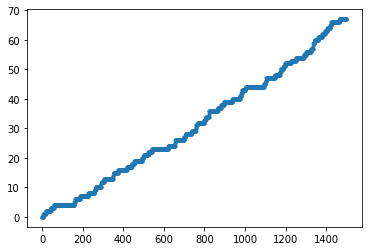

In [ ]:
cum_rewards_2 = np.cumsum(all_rewards)
plt.plot(range(1500), cum_rewards_2[:1500], ".")
plt.show()

In [ ]:
cum_rewards_2[1499]

67

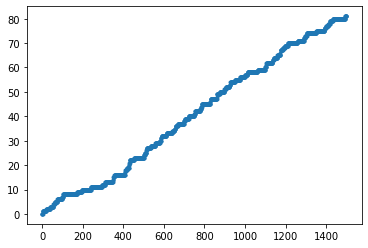

In [ ]:
import matplotlib.pyplot as plt

cum_rewards_10 = np.cumsum(all_rewards)
plt.plot(range(1500), cum_rewards_10[:1500], ".")
plt.show()10

In [ ]:
cum_rewards_10[1500]

81

We'll try the same thing with a GMM over the user features.

In [ ]:
num_particles = 2
K = 10
D = pca.shape[1]
num_users = len(idx_to_user)
num_contexts = 25
num_items = pca.shape[0]

# For Dirichlet prior
# eta = np.ones(K)

# For Gaussian prior
mu_0 = np.zeros(D)
sigma_0 = np.eye(D)
alpha = 1.0
beta = 1.0

In [ ]:
def get_contexts(user_idx, num_contexts):
  user = idx_to_user[user_idx]
  items = user_to_items[user]
  items_idx = np.array([item_to_idx[item] for item in items if item in item_set])

  good_item_idx = np.random.choice(items_idx, 1)
  good_item_context = pca[good_item_idx]
  bad_items_idx = np.random.choice(np.setdiff1d(range(num_items), items_idx), num_contexts - 1, replace=False) 
  bad_items_contexts = pca[bad_items_idx]
    
  contexts = np.vstack((good_item_context, bad_items_contexts))
  rewards = np.array([1] + (num_contexts - 1) * [0]) #-1/(num_contexts - 1)])
  idxs = np.concatenate((good_item_idx, bad_items_idx))

  return contexts, rewards, idxs

In [ ]:
def evaluate(u, particles):
  cu_rewards = np.zeros(num_contexts)
  for particle in particles:
    p = particle["p"][u, :]
    item_feats, r_rewards, item_idxs = get_contexts(u, num_contexts)
    for i in range(item_feats.shape[0]):
      cu_rewards[i] += np.random.normal(item_feats[i, :]@p, particle["sigma"][item_idxs[i]])
  av_rewards = cu_rewards / len(particles)
  return av_rewards, r_rewards, item_idxs

In [ ]:
def update(u, s, r, particles):
  weights = np.zeros(len(particles))
  for idx, particle in enumerate(particles):
    # Review - seems to be some error in the paper
    # for k in range(K): # todo - vectorize
    #  weights[idx] += (1 / (2 * np.pi * particle["sigma"][s])**0.5) * np.exp(-(r - particle["p"][u, :]@pca[s, :])**2) 
    #              * (particle["p"][u, k] / np.sum(particle["p"][u, :])) * (particle["phi"][k, s] / np.sum(particle["phi"][k, :]))
    for k in range(K):  
      weights[idx] += (1 / (2 * np.pi * particle["sigma"][s])**0.5) * np.exp(-(r - particle["p"][u, :]@pca[s, :])**2/(2 * particle["sigma"][s])) * particle["pi"][k] * (1 / (2 * np.pi * particle["amgis"][k])**(D/2)) * np.exp(-np.linalg.norm(particle["mu"][k] - particle["p"][u, :])/(2 * particle["amgis"][k]))
  weights /= np.sum(weights)
  for idx, particle in enumerate(particles):
    flag = np.random.binomial(1, weights[idx])
    if flag == 0:
      continue
    else:
      particle.update({"amgis": np.reciprocal(np.random.gamma(particle["alpha"][1], 1 / particle["beta"][1], size=K))})
      particle.update({"mu": np.array([np.random.multivariate_normal(particle["mu_0"], particle["amgis"][i] * particle["Sigma_0"]) for i in range(K)])})
      particle.update({"sigma": np.reciprocal(np.random.gamma(particle["alpha"][0], 1 / particle["beta"][0], num_items))})
      particle.update({"z": np.random.multinomial(1, particle["pi"], num_users)})
      particle.update({"p": np.array([np.random.multivariate_normal(particle["mu"][np.argmax(particle["z"][i])],
                                                                    particle["amgis"][np.argmax(particle["z"][i])] * particle["Sigma_0"]) for i in range(num_users)])})
  for particle in particles:
    # Sufficient statistics for z
    e_p = np.zeros(K)
    for k in range(K):
      e_p[k] += particle["pi"][k] * (1 / (2 * np.pi * particle["sigma"][s])**0.5) * np.exp(-(r - particle["p"][u, :]@pca[s, :])**2/(2 * particle["sigma"][s])) # (1 / (2 * np.pi * particle["amgis"][k])**(D/2)) * np.exp(-np.linalg.norm(particle["mu"][k] - particle["p"][u, :])/(2 * particle["amgis"][k]))
    e_p /= np.sum(e_p)
    # Resample z as per new posterior
    particle["z"][u, :] = np.random.multinomial(1, e_p)
    # print(particle["z"][u, :])
    # Update hyperparameters with sufficient statistics - based on updates from ICTR
    S_0 = np.linalg.inv(np.linalg.inv(particle["Sigma_0"]) + np.outer(particle["mu"][np.argmax(particle["z"][u, :])], particle["mu"][np.argmax(particle["z"][u, :])]))
    particle["mu_0"] = S_0 @ (np.linalg.inv(particle["Sigma_0"]) @ particle["mu_0"] + r * particle["mu"][np.argmax(particle["z"][u, :])])
    particle["alpha"] += 0.5
    particle["beta"] += 0.5 * (r - particle["p"][u, :]@pca[s, :])**2
    particle["pi"] *= K
    particle["pi"][np.argmax(particle["z"][u, :])] += r
    particle["pi"] /= (K + r)
    particle["Sigma_0"] = S_0
    # print(particle["lambda"]) 
    # particle["eta"][s] += r
    # print(particle["eta"][s], particle["eta"])
    # Resample everything
    particle.update({"amgis": np.reciprocal(np.random.gamma(particle["alpha"][1], 1 / particle["beta"][1], size=K))})
    particle.update({"mu": np.array([np.random.multivariate_normal(particle["mu_0"], particle["amgis"][i] * particle["Sigma_0"]) for i in range(K)])})
    particle.update({"sigma": np.reciprocal(np.random.gamma(particle["alpha"][0], 1 / particle["beta"][0], num_items))})
    particle.update({"p": np.array([np.random.multivariate_normal(particle["mu"][np.argmax(particle["z"][i])],
                                                                  particle["amgis"][np.argmax(particle["z"][i])] * particle["Sigma_0"]) for i in range(num_users)])})

In [ ]:
particles = []
for _ in range(num_particles):
  particle = {"pi": np.ones(K) / K, "alpha": np.array([alpha, alpha]), "beta": np.array([beta, beta]), "mu_0": mu_0, "Sigma_0": sigma_0}
  particle.update({"amgis": np.reciprocal(np.random.gamma(particle["alpha"][1], 1 / particle["beta"][1], size=K))})
  particle.update({"mu": np.array([np.random.multivariate_normal(particle["mu_0"], particle["amgis"][i] * particle["Sigma_0"]) for i in range(K)])})
  particle.update({"sigma": np.reciprocal(np.random.gamma(particle["alpha"][0], 1 / particle["beta"][0], num_items))})
  particle.update({"z": np.random.multinomial(1, particle["pi"], num_users)})
  particle.update({"p": np.array([np.random.multivariate_normal(particle["mu"][np.argmax(particle["z"][i])],
                                                                particle["amgis"][np.argmax(particle["z"][i])] * particle["Sigma_0"]) for i in range(num_users)])})
  particles.append(particle)

In [ ]:
T = 1500
cu_r = 0.0
allr2 = []
for t in range(T):
  if t % 500 == 0:
    print(t, cu_r)
  u = np.random.choice(num_users)
  #print(particles[0]["eta"])
  av_rewards, r_rewards, item_idxs = evaluate(u, particles)
  #print(particles[0]["eta"])
  s = np.argmax(av_rewards)
  r = r_rewards[s]
  s = item_idxs[s]
  cu_r += r
  allr2.append(r)
  update(u, s, r, particles)

KeyboardInterrupt: ignored

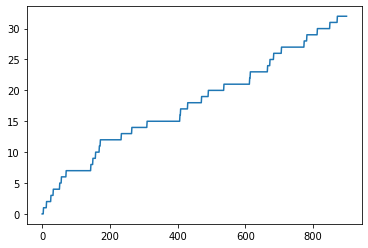

In [ ]:
plt.plot(range(900), np.cumsum(allr2)[:900], "-")
plt.show()

In [ ]:
cum_r2 = np.cumsum(allr2)
cum_r2[-1]

35

In [ ]:
cum_rewards_2[964]

40

In [ ]:
dp_r = np.load("cum_rewards.npy")

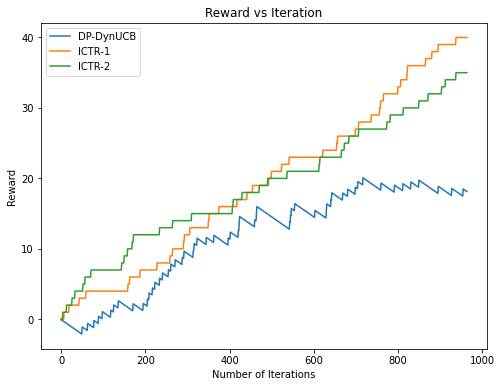

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(range(965), dp_r[:965], "-", label = "DP-DynUCB")
plt.plot(range(965), cum_rewards_2[:965], "-", label = "ICTR-1")
plt.plot(range(965), cum_r2, "-", label = "ICTR-2")
plt.xlabel("Number of Iterations")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.legend()
plt.show()